In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
file_path = r'C:\Users\CHOI.DESKTOP-R51MDOU\OneDrive - 가천대학교\바탕 화면\Coding\AI Introduction\abalone.csv'
df = pd.read_csv(file_path)
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [4]:
columns = ['Sex']

In [5]:
label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [6]:
df.drop(columns = 'id')

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [8]:
# 데이터와 타겟 분리
X = df.drop('Sex', axis = 1).values
y = df['Sex'].values

In [9]:
# 데이터의 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 특성과 타겟 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((3341, 9), (836, 9), (3341,), (836,))

In [11]:
# pytorch tensor로 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [16]:
# DataLoader 생성

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 18, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 18, shuffle = False)

In [22]:
# model 정의
class AbaloneDense(nn.Module):
    def __init__(self):
        super(AbaloneDense, self).__init__()
        self.fc1 = nn.Linear(9, 18)
        self.fc2 = nn.Linear(18, 36)
        self.fc3 = nn.Linear(36, 72)
        self.fc4 = nn.Linear(72, 36)
        self.fc5 = nn.Linear(36, 9)
        self.fc6 = nn.Linear(9, 3)  # 3 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize the model, loss function, and optimizer
model = AbaloneDense()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [28]:
# loss와 정확도 저장용 변수
train_losses = []
test_accuracies = []

# 학습 루프
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("학습 완료.")

Epoch 1/40, Loss: 0.5021, Accuracy: 53.83%
Epoch 2/40, Loss: 0.5215, Accuracy: 54.67%
Epoch 3/40, Loss: 0.5077, Accuracy: 57.18%
Epoch 4/40, Loss: 0.4926, Accuracy: 56.22%
Epoch 5/40, Loss: 0.4912, Accuracy: 54.43%
Epoch 6/40, Loss: 0.5147, Accuracy: 55.98%
Epoch 7/40, Loss: 0.4987, Accuracy: 55.14%
Epoch 8/40, Loss: 0.4724, Accuracy: 53.59%
Epoch 9/40, Loss: 0.5149, Accuracy: 55.74%
Epoch 10/40, Loss: 0.4965, Accuracy: 55.02%
Epoch 11/40, Loss: 0.5088, Accuracy: 55.62%
Epoch 12/40, Loss: 0.4801, Accuracy: 54.07%
Epoch 13/40, Loss: 0.4769, Accuracy: 54.31%
Epoch 14/40, Loss: 0.4831, Accuracy: 53.71%
Epoch 15/40, Loss: 0.4787, Accuracy: 54.67%
Epoch 16/40, Loss: 0.4781, Accuracy: 55.26%
Epoch 17/40, Loss: 0.4752, Accuracy: 55.50%
Epoch 18/40, Loss: 0.4558, Accuracy: 53.11%
Epoch 19/40, Loss: 0.4939, Accuracy: 55.50%
Epoch 20/40, Loss: 0.4869, Accuracy: 53.83%
Epoch 21/40, Loss: 0.4514, Accuracy: 55.50%
Epoch 22/40, Loss: 0.4782, Accuracy: 53.83%
Epoch 23/40, Loss: 0.4730, Accuracy: 54.7

In [29]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average = 'weighted')
precision = precision_score(all_labels, all_predictions, average = 'weighted')
recall = recall_score(all_labels, all_predictions, average = 'weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[108  34 107]
 [ 30 228  33]
 [116  53 127]]
F1 Score: 0.55
Precision: 0.55
Recall: 0.55
Specificity: 0.78


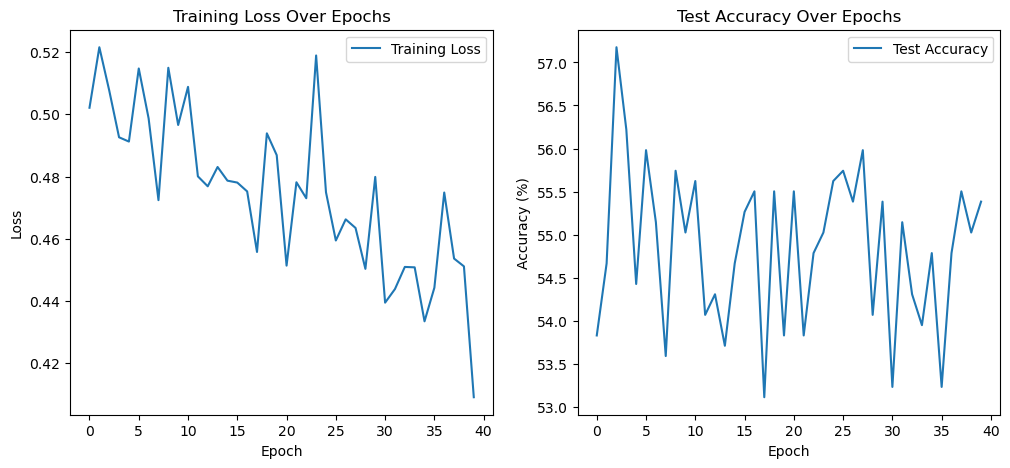

In [30]:
# Plot the loss and accuracy
plt.figure(figsize = (12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

In [31]:
df.drop(columns = 'Sex')

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [32]:
# 데이터와 타겟 분리
X = df.drop('Whole_weight', axis = 1).values
y = df['Whole_weight'].values

In [33]:
# 데이터의 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 특성과 타겟 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((3341, 9), (836, 9), (3341,), (836,))

In [35]:
# pytorch tensor로 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [36]:
# DataLoader 생성

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3341, 9]),
 torch.Size([836, 9]),
 torch.Size([3341]),
 torch.Size([836]))

In [38]:
# model 정의
class AbaloneDenseRegression(nn.Module):
    def __init__(self):
        super(AbaloneDenseRegression, self).__init__()
        self.fc1 = nn.Linear(9, 18)
        self.fc2 = nn.Linear(18, 72)
        self.fc3 = nn.Linear(72, 36)
        self.fc4 = nn.Linear(36, 9)
        self.fc5 = nn.Linear(9, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model = AbaloneDenseRegression()

In [39]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [40]:
# loss와 평가 지표 저장용 변수
train_losses = []
test_losses = []
pred_value = torch.tensor([], dtype = torch.float)
real_value = torch.tensor([], dtype = torch.float)

# 학습 루프
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
        labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    pred_value = torch.tensor([], dtype=torch.float)
    real_value = torch.tensor([], dtype=torch.float)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
            labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
            pred_value = torch.cat((pred_value, outputs), 0)
            real_value = torch.cat((real_value, labels), 0)
            test_loss += criterion(outputs, labels).item()

        # Calculate average test loss
        test_losses.append(test_loss / len(test_dataloader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

print("학습 완료.")


Epoch 1/30, Train Loss: 0.1295, Test Loss: 0.0423
Epoch 2/30, Train Loss: 0.0432, Test Loss: 0.0312
Epoch 3/30, Train Loss: 0.0343, Test Loss: 0.0271
Epoch 4/30, Train Loss: 0.0303, Test Loss: 0.0262
Epoch 5/30, Train Loss: 0.0266, Test Loss: 0.0255
Epoch 6/30, Train Loss: 0.0244, Test Loss: 0.0253
Epoch 7/30, Train Loss: 0.0231, Test Loss: 0.0217
Epoch 8/30, Train Loss: 0.0219, Test Loss: 0.0203
Epoch 9/30, Train Loss: 0.0214, Test Loss: 0.0255
Epoch 10/30, Train Loss: 0.0201, Test Loss: 0.0215
Epoch 11/30, Train Loss: 0.0199, Test Loss: 0.0243
Epoch 12/30, Train Loss: 0.0188, Test Loss: 0.0229
Epoch 13/30, Train Loss: 0.0188, Test Loss: 0.0202
Epoch 14/30, Train Loss: 0.0177, Test Loss: 0.0253
Epoch 15/30, Train Loss: 0.0177, Test Loss: 0.0213
Epoch 16/30, Train Loss: 0.0173, Test Loss: 0.0275
Epoch 17/30, Train Loss: 0.0176, Test Loss: 0.0247
Epoch 18/30, Train Loss: 0.0166, Test Loss: 0.0208
Epoch 19/30, Train Loss: 0.0170, Test Loss: 0.0252
Epoch 20/30, Train Loss: 0.0175, Test Lo

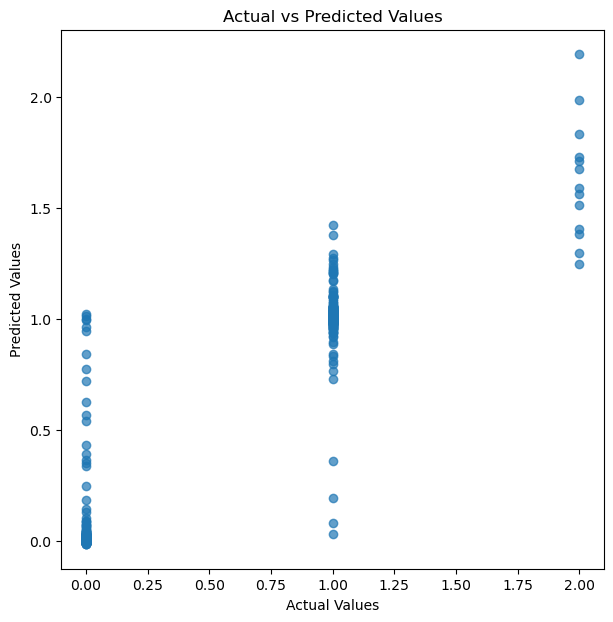

In [41]:
# 예측 값과 실제 값 저장용 변수 초기화
pred_value = torch.tensor([], dtype=torch.float)
real_value = torch.tensor([], dtype=torch.float)

# 테스트 데이터셋에서 예측 값과 실제 값 추출
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
        labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
        pred_value = torch.cat((pred_value, outputs), 0)
        real_value = torch.cat((real_value, labels), 0)

# 예측 값과 실제 값 산점도 그리기
plt.figure(figsize = (7, 7))
plt.scatter(real_value.numpy(), pred_value.numpy(), alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
